In [1]:
# Load library imports
import os
import sys
import torch
import random
import logging
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from pyproj import Transformer
from shapely.geometry import box
from datetime import datetime, timedelta

# Load project Imports
from src.utils.config_loader import load_project_config
from src.graph_building.graph_construction import build_mesh, \
    define_catchment_polygon
from src.data_ingestion.spatial_transformations import find_catchment_boundary
from src.data_ingestion.timeseries_data_ingestion import find_haduk_file_names, \
    load_era5_land_data

In [2]:
# Set up logger config
logging.basicConfig(
    level=logging.INFO,
   format='%(levelname)s - %(message)s',
#    format='%(asctime)s - %(levelname)s - %(name)s - %(message)s',
    handlers=[logging.StreamHandler(sys.stdout)]
)

# Set up logger for file and load config file for paths and params
logger = logging.getLogger(__name__)
config = load_project_config(config_path="config/project_config.yaml")
notebook = True

# Set up seeding to define global states
random_seed = config["global"]["pipeline_settings"]["random_seed"]
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Define notebook demo catchment
catchments_to_process = config["global"]["pipeline_settings"]["catchments_to_process"]
catchment = catchments_to_process[0]
run_defra_API_calls = config["global"]["pipeline_settings"]["run_defra_api"]  # True to run API calls

logger.info(f"Show Notebook Outputs: {notebook}")
logger.info(f"Notebook Demo Catchment: {catchment.capitalize()}")

INFO - Loading configuration from: /Users/charlotte/Desktop/Dissertation_Code/config/project_config.yaml
INFO - Show Notebook Outputs: True
INFO - Notebook Demo Catchment: Eden


### Build mesh ###

To align ingested data with

In [3]:
# Select Catchment area from country wide gdf
define_catchment_polygon(
    england_catchment_gdf_path=config[catchment]['paths']['gis_catchment_boundary'],
    target_mncat=config[catchment]['target_mncat'],
    catchment=catchment,
    polygon_output_path=config[catchment]['paths']['gis_catchment_dir']
)

INFO - Eden and Esk boundary polygon(s) extracted from England data.
data/01_raw/eden/gis/eden_catchment_boundary/eden_combined_boundary.geojson
INFO - Combined Eden and Esk boundary saved to: data/01_raw/eden/gis/eden_catchment_boundary/eden_combined_boundary.geojson


In [4]:
# NB: mesh_nodes_gdf are the centroid coords, mesh_cells_gdf_polygons are polygons for e.g. averaging area
mesh_nodes_table, mesh_nodes_gdf, mesh_cells_gdf_polygons, catchment_polygon = build_mesh(
    shape_filepath=config[catchment]['paths']['gis_catchment_dir'],
    output_path=config[catchment]['paths']['mesh_nodes_output'],
    catchment=catchment,
    grid_resolution=config[catchment]['preprocessing']['graph_construction']['grid_resolution']
)

INFO - BUILD_MESH: Starting mesh construction with input: data/01_raw/eden/gis/eden_catchment_boundary/eden_combined_boundary.geojson and resolution: 1000m

INFO - Finding eden catchment spatial boundaries...

INFO - Loading  boundary from: data/01_raw/eden/gis/eden_catchment_boundary/eden_combined_boundary.geojson
INFO - Single polygon found in the catchment boundary.
INFO - Catchment bounding box: min_x=325093.81960000005, min_y=495490.0, max_x=389010.0, max_y=590440.0

INFO - Aligned minx: 325000.0, miny: 495000.0, maxx: 390000.0, maxy: 591000.0
INFO - Number of x-coordinates (bottom-left): 66
INFO - Number of y-coordinates (bottom-left): 97

INFO - Generated 6402 grid cells (centroids and polygons) within bounding box (before filtering).
INFO - Filtered down to catchment boundary containing 2750 nodes

INFO - First few mesh nodes (centroids with coordinates):

     node_id   easting  northing       lon        lat
64         0  325500.0  559500.0 -3.163979  54.924606
130        1  3

### Rainfall Ingestion and Preprocessing ###

In [5]:
haduk_urls = find_haduk_file_names(
    start_date=config["global"]["data_ingestion"]["model_start_date"],
    end_date=config["global"]["data_ingestion"]["model_end_date"],
    base_url = config["global"]["paths"]["HAD_UK_rainfall_url"]
)

Continue with the following once https://www.ceda.ac.uk/status/ allows.

In [6]:
os.environ["NETRC"] = os.path.abspath("ceda_credentials.netrc")
url = haduk_urls[0]

try:
    ds = xr.open_dataset(url, engine="netcdf4")
    print(ds)
except OSError as e:
    print("Failed to open dataset. This may be due to CEDA login issues. Check https://www.ceda.ac.uk/status/")
    print(e)

Failed to open dataset. This may be due to CEDA login issues. Check https://www.ceda.ac.uk/status/
[Errno -72] NetCDF: Malformed or inaccessible DAP2 DDS or DAP4 DMR response: 'https://dap.ceda.ac.uk/thredds/dodsC/badc/ukmo-hadobs/data/insitu/MOHC/HadOBS/HadUK-Grid/v1.3.0.ceda/1km/rainfall/day/v20240514/rainfall_hadukgrid_uk_1km_day_20140101-20140131.nc'


syntax error, unexpected WORD_WORD, expecting SCAN_ATTR or SCAN_DATASET or SCAN_ERROR
context: <!DOCTYPE^ html><html lang="en"> <head> <meta charset="utf-8"> <title>Login</title> <meta name="viewport" content="width=device-width, initial-scale=1"> <meta http-equiv="X-UA-Compatible" content="IE=edge" />     <!-- Bootstrap Core CSS --> <link rel="stylesheet" href="https://artefacts.ceda.ac.uk/themes/orgtheme_ceda_serv/0.2/4/flatly/bootstrap.css" media="screen"> <!-- Custom CSS --> <link rel="stylesheet" href="https://artefacts.ceda.ac.uk/themes/orgtheme_ceda_serv/0.2/_assets/css/custom.min.css"> <link rel="stylesheet" href="https://artefacts.ceda.ac.uk/themes/orgtheme_ceda_serv/0.2/_assets/css/org-custom.css">   <link href="/static/fwtheme_django/css/fw-custom.css" rel="stylesheet"> <!-- Custom Fonts --> <link rel="stylesheet" href="https://use.fontawesome.com/releases/v5.0.10/css/all.css" integrity="sha384-+d0P83n9kaQMCwj8F4RJB66tzIwOKmrdb46+porD/OvrJ+37WqIM7UoBtwHO6Nlg" crossorigin="an

### Temperature Ingestion and Preprocessing ###

Continue with the following once https://www.ceda.ac.uk/status/ allows.

### Surface Pressure Ingestion and Preprocessing ###

2025-07-12 14:39:31,295 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


INFO - [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO - Finding eden catchment spatial boundaries...

INFO - Loading  boundary from: data/01_raw/eden/gis/eden_catchment_boundary/eden_combined_boundary.geojson
INFO - Single polygon found in the catchment boundary.
INFO - Catchment bounding box: min_x=325093.81960000005, min_y=495490.0, max_x=389010.0, max_y=590440.0

INFO - Converting 'easting'/'northing' to 'lon'/'lat'...
INFO - Catchment BBox (lat/lon): (np.float64(55.20808470523775), np.float64(54.34942479634069), np.float64(-2.1742353207346743), np.float64(-3.153909164951907))
INFO - Catchment polygon CRS: EPSG:27700
INFO - Catchment polygon area (approx.): 8231.092448085472 km^2
INFO - Processing GRIB: surface_pressure_2014_01_era5land.grib
INFO - Processing GRIB: surface_pressure_2014_02_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2014_03_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


INFO - Processing GRIB: surface_pressure_2014_04_era5land.grib
INFO - Processing GRIB: surface_pressure_2014_05_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2014_06_era5land.grib
INFO - Processing GRIB: surface_pressure_2014_07_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2014_08_era5land.grib
INFO - Processing GRIB: surface_pressure_2014_09_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2014_10_era5land.grib
INFO - Processing GRIB: surface_pressure_2014_11_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2014_12_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


INFO - Processing GRIB: surface_pressure_2015_01_era5land.grib
INFO - Processing GRIB: surface_pressure_2015_02_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2015_03_era5land.grib
INFO - Processing GRIB: surface_pressure_2015_04_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2015_05_era5land.grib
INFO - Processing GRIB: surface_pressure_2015_06_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2015_07_era5land.grib
INFO - Processing GRIB: surface_pressure_2015_08_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2015_09_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


INFO - Processing GRIB: surface_pressure_2015_10_era5land.grib
INFO - Processing GRIB: surface_pressure_2015_11_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2015_12_era5land.grib
INFO - Processing GRIB: surface_pressure_2016_01_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2016_02_era5land.grib
INFO - Processing GRIB: surface_pressure_2016_03_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2016_04_era5land.grib
INFO - Processing GRIB: surface_pressure_2016_05_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2016_06_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


INFO - Processing GRIB: surface_pressure_2016_07_era5land.grib
INFO - Processing GRIB: surface_pressure_2016_08_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2016_09_era5land.grib
INFO - Processing GRIB: surface_pressure_2016_10_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2016_11_era5land.grib
INFO - Processing GRIB: surface_pressure_2016_12_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2017_01_era5land.grib
INFO - Processing GRIB: surface_pressure_2017_02_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2017_03_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


INFO - Processing GRIB: surface_pressure_2017_04_era5land.grib
INFO - Processing GRIB: surface_pressure_2017_05_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2017_06_era5land.grib
INFO - Processing GRIB: surface_pressure_2017_07_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2017_08_era5land.grib
INFO - Processing GRIB: surface_pressure_2017_09_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2017_10_era5land.grib
INFO - Processing GRIB: surface_pressure_2017_11_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2017_12_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


INFO - Processing GRIB: surface_pressure_2018_01_era5land.grib
INFO - Processing GRIB: surface_pressure_2018_02_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2018_03_era5land.grib
INFO - Processing GRIB: surface_pressure_2018_04_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2018_05_era5land.grib
INFO - Processing GRIB: surface_pressure_2018_06_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2018_07_era5land.grib
INFO - Processing GRIB: surface_pressure_2018_08_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2018_09_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


INFO - Processing GRIB: surface_pressure_2018_10_era5land.grib
INFO - Processing GRIB: surface_pressure_2018_11_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2018_12_era5land.grib
INFO - Processing GRIB: surface_pressure_2019_01_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2019_02_era5land.grib
INFO - Processing GRIB: surface_pressure_2019_03_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2019_04_era5land.grib
INFO - Processing GRIB: surface_pressure_2019_05_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2019_06_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


INFO - Processing GRIB: surface_pressure_2019_07_era5land.grib
INFO - Processing GRIB: surface_pressure_2019_08_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2019_09_era5land.grib
INFO - Processing GRIB: surface_pressure_2019_10_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2019_11_era5land.grib
INFO - Processing GRIB: surface_pressure_2019_12_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2020_01_era5land.grib
INFO - Processing GRIB: surface_pressure_2020_02_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2020_03_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


INFO - Processing GRIB: surface_pressure_2020_04_era5land.grib
INFO - Processing GRIB: surface_pressure_2020_05_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2020_06_era5land.grib
INFO - Processing GRIB: surface_pressure_2020_07_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2020_08_era5land.grib
INFO - Processing GRIB: surface_pressure_2020_09_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2020_10_era5land.grib
INFO - Processing GRIB: surface_pressure_2020_11_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2020_12_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


INFO - Processing GRIB: surface_pressure_2021_01_era5land.grib
INFO - Processing GRIB: surface_pressure_2021_02_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2021_03_era5land.grib
INFO - Processing GRIB: surface_pressure_2021_04_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2021_05_era5land.grib
INFO - Processing GRIB: surface_pressure_2021_06_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2021_07_era5land.grib
INFO - Processing GRIB: surface_pressure_2021_08_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2021_09_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


INFO - Processing GRIB: surface_pressure_2021_10_era5land.grib
INFO - Processing GRIB: surface_pressure_2021_11_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2021_12_era5land.grib
INFO - Processing GRIB: surface_pressure_2022_01_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2022_02_era5land.grib
INFO - Processing GRIB: surface_pressure_2022_03_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2022_04_era5land.grib
INFO - Processing GRIB: surface_pressure_2022_05_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2022_06_era5land.grib
INFO - Processing GRIB: surface_pressure_2022_07_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2022_08_era5land.grib
INFO - Processing GRIB: surface_pressure_2022_09_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2022_10_era5land.grib
INFO - Processing GRIB: surface_pressure_2022_11_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2022_12_era5land.grib
INFO - Processing GRIB: surface_pressure_2023_01_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2023_02_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


INFO - Processing GRIB: surface_pressure_2023_03_era5land.grib
INFO - Processing GRIB: surface_pressure_2023_04_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2023_05_era5land.grib
INFO - Processing GRIB: surface_pressure_2023_06_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2023_07_era5land.grib
INFO - Processing GRIB: surface_pressure_2023_08_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2023_09_era5land.grib
INFO - Processing GRIB: surface_pressure_2023_10_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2023_11_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


INFO - Processing GRIB: surface_pressure_2023_12_era5land.grib
INFO - Processing GRIB: surface_pressure_2024_01_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2024_02_era5land.grib
INFO - Processing GRIB: surface_pressure_2024_03_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2024_04_era5land.grib
INFO - Processing GRIB: surface_pressure_2024_05_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2024_06_era5land.grib
INFO - Processing GRIB: surface_pressure_2024_07_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2024_08_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


INFO - Processing GRIB: surface_pressure_2024_09_era5land.grib
INFO - Processing GRIB: surface_pressure_2024_10_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: surface_pressure_2024_11_era5land.grib
INFO - Processing GRIB: surface_pressure_2024_12_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Saving combined daily surface_pressure from 2014-2024 to: data/02_processed/eden/hydroclimatic/surface_pressure/surface_pressure_daily_2014-2024_era5land.nc
INFO - ERA5-Land surface_pressure data retrieval and processing complete.
INFO - Saving catchment-summed daily surface_pressure to CSV: data/02_processed/eden/hydroclimatic/surface_pressure/surface_pressure_daily_catchment_mean.csv
INFO - DEBUG: Entering _compute_weighted_aggregation for surface_pressure
INFO - DEBUG: full_da dims: ('latitude', 'longitude', 'time'), coords: ['latitude', 'longitude', 'time']
INFO - DEBUG: full_da latitude: [54.3  54.35 54.4  54.45 54.5  54.55 54.6  54.65 54.7  54.75 54.8  54.85
 54.9  54.95 55.   55.05 55.1  55.15 55.2 ]
INFO - DEBUG: full_da longitude: [-3.2  -3.15 -3.1  -3.05 -3.   -2.95 -2.9  -2.85 -2.8  -2.75 -2.7  -2.65
 -2.6  -2.55 -2.5  -2.45 -2.4  -2.35 -2.3  -2.25 -2.2 ]
INFO - Grid cell resolution (deg): 0.05, 0.05
INFO - Total grid cells: 399
INFO - Adjusting outlying values in ede

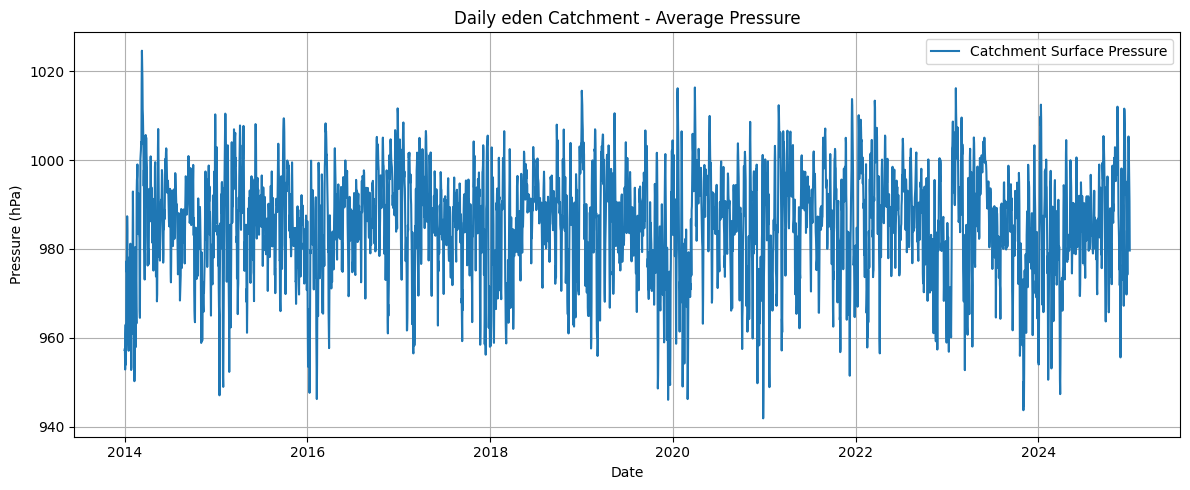

In [7]:
pressure_data = load_era5_land_data(
    catchment=catchment,
    shape_filepath=config[catchment]['paths']['gis_catchment_dir'],
    required_crs=27700,
    cdsapi_path=config["global"]["paths"]["CDSAPI_path"],
    start_date=config["global"]["data_ingestion"]["model_start_date"],
    end_date=config["global"]["data_ingestion"]["model_end_date"],
    run_era5_land_api=config["global"]["pipeline_settings"]["run_era5_land_api"],
    raw_output_dir=config[catchment]["paths"]["sp_raw_output_dir"],
    processed_output_dir=config[catchment]["paths"]["sp_processed_output_dir"],
    csv_path=config[catchment]["paths"]["sp_csv_path"],
    fig_path=config[catchment]["paths"]["sp_fig_path"],
    era5_feat='sp',
    era5_long='surface_pressure',
    feat_name='surface_pressure',
    aggregation_type='mean'
)

### AET Ingestion and Preprocessing ###

2025-07-12 14:39:56,798 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


INFO - [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO - Finding eden catchment spatial boundaries...

INFO - Loading  boundary from: data/01_raw/eden/gis/eden_catchment_boundary/eden_combined_boundary.geojson
INFO - Single polygon found in the catchment boundary.
INFO - Catchment bounding box: min_x=325093.81960000005, min_y=495490.0, max_x=389010.0, max_y=590440.0

INFO - Converting 'easting'/'northing' to 'lon'/'lat'...
INFO - Catchment BBox (lat/lon): (np.float64(55.20808470523775), np.float64(54.34942479634069), np.float64(-2.1742353207346743), np.float64(-3.153909164951907))
INFO - Catchment polygon CRS: EPSG:27700
INFO - Catchment polygon area (approx.): 8231.092448085472 km^2
INFO - Processing GRIB: total_evaporation_2014_01_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


INFO - Processing GRIB: total_evaporation_2014_02_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


INFO - Processing GRIB: total_evaporation_2014_03_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


INFO - Processing GRIB: total_evaporation_2014_04_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


INFO - Processing GRIB: total_evaporation_2014_05_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


INFO - Processing GRIB: total_evaporation_2014_06_era5land.grib
INFO - Processing GRIB: total_evaporation_2014_07_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2014_08_era5land.grib
INFO - Processing GRIB: total_evaporation_2014_09_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2014_10_era5land.grib
INFO - Processing GRIB: total_evaporation_2014_11_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2014_12_era5land.grib
INFO - Processing GRIB: total_evaporation_2015_01_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2015_02_era5land.grib
INFO - Processing GRIB: total_evaporation_2015_03_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2015_04_era5land.grib
INFO - Processing GRIB: total_evaporation_2015_05_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2015_06_era5land.grib
INFO - Processing GRIB: total_evaporation_2015_07_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2015_08_era5land.grib
INFO - Processing GRIB: total_evaporation_2015_09_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2015_10_era5land.grib
INFO - Processing GRIB: total_evaporation_2015_11_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2015_12_era5land.grib
INFO - Processing GRIB: total_evaporation_2016_01_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2016_02_era5land.grib
INFO - Processing GRIB: total_evaporation_2016_03_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2016_04_era5land.grib
INFO - Processing GRIB: total_evaporation_2016_05_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2016_06_era5land.grib
INFO - Processing GRIB: total_evaporation_2016_07_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2016_08_era5land.grib
INFO - Processing GRIB: total_evaporation_2016_09_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2016_10_era5land.grib
INFO - Processing GRIB: total_evaporation_2016_11_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2016_12_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


INFO - Processing GRIB: total_evaporation_2017_01_era5land.grib
INFO - Processing GRIB: total_evaporation_2017_02_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2017_03_era5land.grib
INFO - Processing GRIB: total_evaporation_2017_04_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2017_05_era5land.grib
INFO - Processing GRIB: total_evaporation_2017_06_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2017_07_era5land.grib
INFO - Processing GRIB: total_evaporation_2017_08_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2017_09_era5land.grib
INFO - Processing GRIB: total_evaporation_2017_10_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2017_11_era5land.grib
INFO - Processing GRIB: total_evaporation_2017_12_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2018_01_era5land.grib
INFO - Processing GRIB: total_evaporation_2018_02_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2018_03_era5land.grib
INFO - Processing GRIB: total_evaporation_2018_04_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2018_05_era5land.grib
INFO - Processing GRIB: total_evaporation_2018_06_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2018_07_era5land.grib
INFO - Processing GRIB: total_evaporation_2018_08_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2018_09_era5land.grib
INFO - Processing GRIB: total_evaporation_2018_10_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2018_11_era5land.grib
INFO - Processing GRIB: total_evaporation_2018_12_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2019_01_era5land.grib
INFO - Processing GRIB: total_evaporation_2019_02_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2019_03_era5land.grib
INFO - Processing GRIB: total_evaporation_2019_04_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2019_05_era5land.grib
INFO - Processing GRIB: total_evaporation_2019_06_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2019_07_era5land.grib
INFO - Processing GRIB: total_evaporation_2019_08_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2019_09_era5land.grib
INFO - Processing GRIB: total_evaporation_2019_10_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2019_11_era5land.grib
INFO - Processing GRIB: total_evaporation_2019_12_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2020_01_era5land.grib
INFO - Processing GRIB: total_evaporation_2020_02_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2020_03_era5land.grib
INFO - Processing GRIB: total_evaporation_2020_04_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2020_05_era5land.grib
INFO - Processing GRIB: total_evaporation_2020_06_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2020_07_era5land.grib
INFO - Processing GRIB: total_evaporation_2020_08_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2020_09_era5land.grib
INFO - Processing GRIB: total_evaporation_2020_10_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2020_11_era5land.grib
INFO - Processing GRIB: total_evaporation_2020_12_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2021_01_era5land.grib
INFO - Processing GRIB: total_evaporation_2021_02_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2021_03_era5land.grib
INFO - Processing GRIB: total_evaporation_2021_04_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2021_05_era5land.grib
INFO - Processing GRIB: total_evaporation_2021_06_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2021_07_era5land.grib
INFO - Processing GRIB: total_evaporation_2021_08_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2021_09_era5land.grib
INFO - Processing GRIB: total_evaporation_2021_10_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2021_11_era5land.grib
INFO - Processing GRIB: total_evaporation_2021_12_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2022_01_era5land.grib
INFO - Processing GRIB: total_evaporation_2022_02_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2022_03_era5land.grib
INFO - Processing GRIB: total_evaporation_2022_04_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2022_05_era5land.grib
INFO - Processing GRIB: total_evaporation_2022_06_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2022_07_era5land.grib
INFO - Processing GRIB: total_evaporation_2022_08_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2022_09_era5land.grib
INFO - Processing GRIB: total_evaporation_2022_10_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2022_11_era5land.grib
INFO - Processing GRIB: total_evaporation_2022_12_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2023_01_era5land.grib
INFO - Processing GRIB: total_evaporation_2023_02_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2023_03_era5land.grib
INFO - Processing GRIB: total_evaporation_2023_04_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2023_05_era5land.grib
INFO - Processing GRIB: total_evaporation_2023_06_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2023_07_era5land.grib
INFO - Processing GRIB: total_evaporation_2023_08_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2023_09_era5land.grib
INFO - Processing GRIB: total_evaporation_2023_10_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2023_11_era5land.grib
INFO - Processing GRIB: total_evaporation_2023_12_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2024_01_era5land.grib
INFO - Processing GRIB: total_evaporation_2024_02_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2024_03_era5land.grib
INFO - Processing GRIB: total_evaporation_2024_04_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2024_05_era5land.grib
INFO - Processing GRIB: total_evaporation_2024_06_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2024_07_era5land.grib
INFO - Processing GRIB: total_evaporation_2024_08_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2024_09_era5land.grib
INFO - Processing GRIB: total_evaporation_2024_10_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: total_evaporation_2024_11_era5land.grib
INFO - Processing GRIB: total_evaporation_2024_12_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Saving combined daily aet from 2014-2024 to: data/02_processed/eden/hydroclimatic/aet/aet_daily_2014-2024_era5land.nc
INFO - ERA5-Land aet data retrieval and processing complete.
INFO - Saving catchment-summed daily aet to CSV: data/02_processed/eden/hydroclimatic/aet/aet_daily_catchment_sum.csv
INFO - DEBUG: Entering _compute_weighted_aggregation for aet
INFO - DEBUG: full_da dims: ('latitude', 'longitude', 'time'), coords: ['latitude', 'longitude', 'time']
INFO - DEBUG: full_da latitude: [55.2 55.1 55.  54.9 54.8 54.7 54.6 54.5 54.4 54.3]
INFO - DEBUG: full_da longitude: [-3.2 -3.1 -3.  -2.9 -2.8 -2.7 -2.6 -2.5 -2.4 -2.3 -2.2]
INFO - Grid cell resolution (deg): 0.10, 0.10
INFO - Total grid cells: 110
Max value in dataset: [1.68396003e+08]
Min value in dataset: [0.]


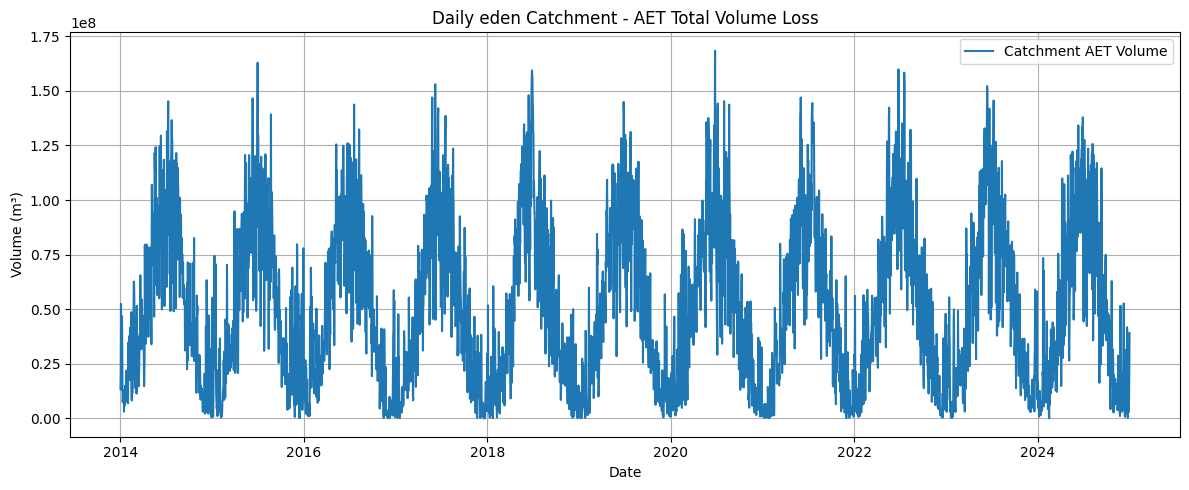

In [8]:
aet_data = load_era5_land_data(
    catchment=catchment,
    shape_filepath=config[catchment]['paths']['gis_catchment_dir'],
    required_crs=27700,
    cdsapi_path=config["global"]["paths"]["CDSAPI_path"],
    start_date=config["global"]["data_ingestion"]["model_start_date"],
    end_date=config["global"]["data_ingestion"]["model_end_date"],
    run_era5_land_api=config["global"]["pipeline_settings"]["run_era5_land_api"],
    raw_output_dir=config[catchment]["paths"]["aet_raw_output_dir"],
    processed_output_dir=config[catchment]["paths"]["aet_processed_output_dir"],
    csv_path=config[catchment]["paths"]["aet_csv_path"],
    fig_path=config[catchment]["paths"]["aet_fig_path"],
    era5_feat='e',
    era5_long='total_evaporation',
    feat_name='aet',
    aggregation_type='sum'
)

### 2m Surface Temperature Ingestion and Preprocessing ###

2025-07-12 14:40:19,550 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


INFO - [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO - Finding eden catchment spatial boundaries...

INFO - Loading  boundary from: data/01_raw/eden/gis/eden_catchment_boundary/eden_combined_boundary.geojson
INFO - Single polygon found in the catchment boundary.
INFO - Catchment bounding box: min_x=325093.81960000005, min_y=495490.0, max_x=389010.0, max_y=590440.0

INFO - Converting 'easting'/'northing' to 'lon'/'lat'...
INFO - Catchment BBox (lat/lon): (np.float64(55.20808470523775), np.float64(54.34942479634069), np.float64(-2.1742353207346743), np.float64(-3.153909164951907))
INFO - Catchment polygon CRS: EPSG:27700
INFO - Catchment polygon area (approx.): 8231.092448085472 km^2
INFO - Processing GRIB: 2m_temp_2014_01_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


INFO - Processing GRIB: 2m_temp_2014_02_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


INFO - Processing GRIB: 2m_temp_2014_03_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


INFO - Processing GRIB: 2m_temp_2014_04_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


INFO - Processing GRIB: 2m_temp_2014_05_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


INFO - Processing GRIB: 2m_temp_2014_06_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


INFO - Processing GRIB: 2m_temp_2014_07_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


INFO - Processing GRIB: 2m_temp_2014_08_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


INFO - Processing GRIB: 2m_temp_2014_09_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


INFO - Processing GRIB: 2m_temp_2014_10_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


INFO - Processing GRIB: 2m_temp_2014_11_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


INFO - Processing GRIB: 2m_temp_2014_12_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


INFO - Processing GRIB: 2m_temp_2015_01_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


INFO - Processing GRIB: 2m_temp_2015_02_era5land.grib
INFO - Processing GRIB: 2m_temp_2015_03_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2015_04_era5land.grib
INFO - Processing GRIB: 2m_temp_2015_05_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2015_06_era5land.grib
INFO - Processing GRIB: 2m_temp_2015_07_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2015_08_era5land.grib
INFO - Processing GRIB: 2m_temp_2015_09_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2015_10_era5land.grib
INFO - Processing GRIB: 2m_temp_2015_11_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2015_12_era5land.grib
INFO - Processing GRIB: 2m_temp_2016_01_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2016_02_era5land.grib
INFO - Processing GRIB: 2m_temp_2016_03_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2016_04_era5land.grib
INFO - Processing GRIB: 2m_temp_2016_05_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2016_06_era5land.grib
INFO - Processing GRIB: 2m_temp_2016_07_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2016_08_era5land.grib
INFO - Processing GRIB: 2m_temp_2016_09_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2016_10_era5land.grib
INFO - Processing GRIB: 2m_temp_2016_11_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2016_12_era5land.grib
INFO - Processing GRIB: 2m_temp_2017_01_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2017_02_era5land.grib
INFO - Processing GRIB: 2m_temp_2017_03_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2017_04_era5land.grib
INFO - Processing GRIB: 2m_temp_2017_05_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2017_06_era5land.grib
INFO - Processing GRIB: 2m_temp_2017_07_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2017_08_era5land.grib
INFO - Processing GRIB: 2m_temp_2017_09_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2017_10_era5land.grib
INFO - Processing GRIB: 2m_temp_2017_11_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2017_12_era5land.grib
INFO - Processing GRIB: 2m_temp_2018_01_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2018_02_era5land.grib
INFO - Processing GRIB: 2m_temp_2018_03_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2018_04_era5land.grib
INFO - Processing GRIB: 2m_temp_2018_05_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2018_06_era5land.grib
INFO - Processing GRIB: 2m_temp_2018_07_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2018_08_era5land.grib
INFO - Processing GRIB: 2m_temp_2018_09_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


INFO - Processing GRIB: 2m_temp_2018_10_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2018_11_era5land.grib
INFO - Processing GRIB: 2m_temp_2018_12_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2019_01_era5land.grib
INFO - Processing GRIB: 2m_temp_2019_02_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2019_03_era5land.grib
INFO - Processing GRIB: 2m_temp_2019_04_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2019_05_era5land.grib
INFO - Processing GRIB: 2m_temp_2019_06_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2019_07_era5land.grib
INFO - Processing GRIB: 2m_temp_2019_08_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2019_09_era5land.grib
INFO - Processing GRIB: 2m_temp_2019_10_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2019_11_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


INFO - Processing GRIB: 2m_temp_2019_12_era5land.grib
INFO - Processing GRIB: 2m_temp_2020_01_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2020_02_era5land.grib
INFO - Processing GRIB: 2m_temp_2020_03_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2020_04_era5land.grib
INFO - Processing GRIB: 2m_temp_2020_05_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2020_06_era5land.grib
INFO - Processing GRIB: 2m_temp_2020_07_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2020_08_era5land.grib
INFO - Processing GRIB: 2m_temp_2020_09_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2020_10_era5land.grib
INFO - Processing GRIB: 2m_temp_2020_11_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2020_12_era5land.grib
INFO - Processing GRIB: 2m_temp_2021_01_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2021_02_era5land.grib
INFO - Processing GRIB: 2m_temp_2021_03_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2021_04_era5land.grib
INFO - Processing GRIB: 2m_temp_2021_05_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2021_06_era5land.grib
INFO - Processing GRIB: 2m_temp_2021_07_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2021_08_era5land.grib
INFO - Processing GRIB: 2m_temp_2021_09_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2021_10_era5land.grib
INFO - Processing GRIB: 2m_temp_2021_11_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2021_12_era5land.grib
INFO - Processing GRIB: 2m_temp_2022_01_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2022_02_era5land.grib
INFO - Processing GRIB: 2m_temp_2022_03_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2022_04_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


INFO - Processing GRIB: 2m_temp_2022_05_era5land.grib
INFO - Processing GRIB: 2m_temp_2022_06_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2022_07_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


INFO - Processing GRIB: 2m_temp_2022_08_era5land.grib
INFO - Processing GRIB: 2m_temp_2022_09_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2022_10_era5land.grib
INFO - Processing GRIB: 2m_temp_2022_11_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2022_12_era5land.grib
INFO - Processing GRIB: 2m_temp_2023_01_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2023_02_era5land.grib
INFO - Processing GRIB: 2m_temp_2023_03_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2023_04_era5land.grib
INFO - Processing GRIB: 2m_temp_2023_05_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2023_06_era5land.grib
INFO - Processing GRIB: 2m_temp_2023_07_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2023_08_era5land.grib
INFO - Processing GRIB: 2m_temp_2023_09_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2023_10_era5land.grib
INFO - Processing GRIB: 2m_temp_2023_11_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2023_12_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


INFO - Processing GRIB: 2m_temp_2024_01_era5land.grib
INFO - Processing GRIB: 2m_temp_2024_02_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2024_03_era5land.grib
INFO - Processing GRIB: 2m_temp_2024_04_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2024_05_era5land.grib
INFO - Processing GRIB: 2m_temp_2024_06_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2024_07_era5land.grib
INFO - Processing GRIB: 2m_temp_2024_08_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2024_09_era5land.grib
INFO - Processing GRIB: 2m_temp_2024_10_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Processing GRIB: 2m_temp_2024_11_era5land.grib
INFO - Processing GRIB: 2m_temp_2024_12_era5land.grib


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute 

INFO - Saving combined daily 2m_temp from 2014-2024 to: data/02_processed/eden/hydroclimatic/2meter_temp/2m_temp_daily_2014-2024_era5land.nc
INFO - ERA5-Land 2m_temp data retrieval and processing complete.
INFO - Saving catchment-summed daily 2m_temp to CSV: data/02_processed/eden/hydroclimatic/2meter_temp/2m_temp_daily_catchment_mean.csv
INFO - DEBUG: Entering _compute_weighted_aggregation for 2m_temp
INFO - DEBUG: full_da dims: ('latitude', 'longitude', 'time'), coords: ['latitude', 'longitude', 'time']
INFO - DEBUG: full_da latitude: [55.15 55.05 54.95 54.85 54.75 54.65 54.55 54.45 54.35]
INFO - DEBUG: full_da longitude: [-3.15 -3.05 -2.95 -2.85 -2.75 -2.65 -2.55 -2.45 -2.35 -2.25]
INFO - Grid cell resolution (deg): 0.10, 0.10
INFO - Total grid cells: 90
Max value in dataset: [23.61799351]
Min value in dataset: [-5.07623729]


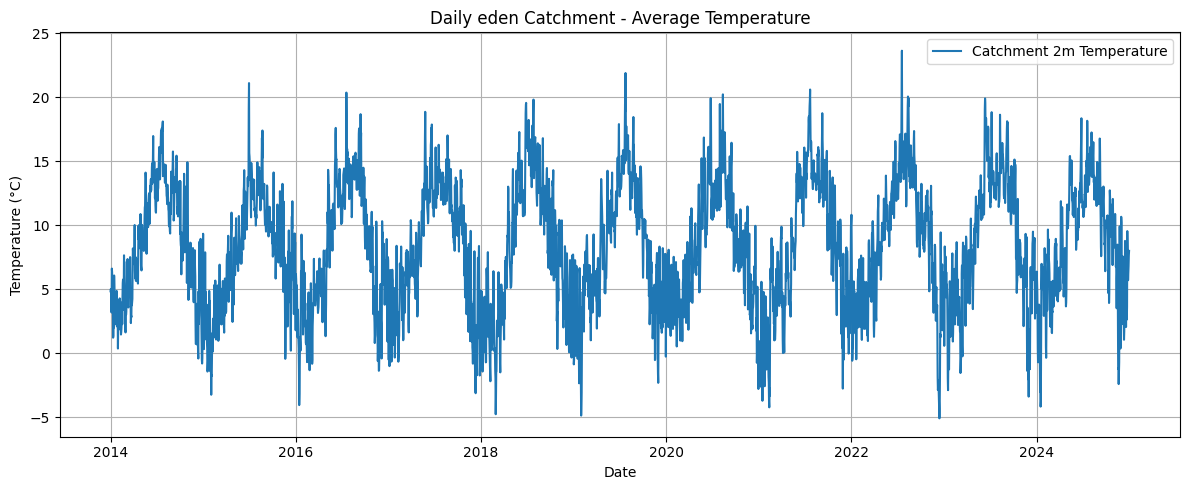

In [9]:
temp_data = load_era5_land_data(
    catchment=catchment,
    shape_filepath=config[catchment]['paths']['gis_catchment_dir'],
    required_crs=27700,
    cdsapi_path=config["global"]["paths"]["CDSAPI_path"],
    start_date=config["global"]["data_ingestion"]["model_start_date"],
    end_date=config["global"]["data_ingestion"]["model_end_date"],
    run_era5_land_api=config["global"]["pipeline_settings"]["run_era5_land_api"],
    raw_output_dir=config[catchment]["paths"]["2t_raw_output_dir"],
    processed_output_dir=config[catchment]["paths"]["2t_processed_output_dir"],
    csv_path=config[catchment]["paths"]["2t_csv_path"],
    fig_path=config[catchment]["paths"]["2t_fig_path"],
    era5_feat='2t',
    era5_long='2m_temperature',
    feat_name='2m_temp',
    aggregation_type='mean'
)

In [10]:
grib_path = 'data/01_raw/eden/hydroclimatic/surface_pressure/surface_pressure_2017_01_era5land.grib'
ds = xr.open_dataset(grib_path, engine='cfgrib')

print(ds['sp'].min().item(), ds['sp'].max().item(), ds['sp'].mean().item())  # print(ds.variables) to see full metadata

93471.625 103135.75 98914.1484375


/Users/charlotte/Desktop/Dissertation_Code/.venv/lib/python3.11/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


In [11]:
# import os
# import re

# def rename_aet_files_to_total_evaporation(directory):
#     """
#     Renames GRIB and index files from 'aet_YYYY_MM_era5land.*' 
#     to 'total_evaporation_YYYY_MM_era5land.*' in the given directory.
#     """
#     renamed_files = 0

#     for filename in os.listdir(directory):
#         if filename.startswith("aet_") and "era5land" in filename:
#             new_filename = re.sub(r'^aet_', 'total_evaporation_', filename)
#             src = os.path.join(directory, filename)
#             dst = os.path.join(directory, new_filename)
#             os.rename(src, dst)
#             renamed_files += 1
#             print(f"Renamed: {filename} -> {new_filename}")

#     print(f"\nDone. Renamed {renamed_files} files in '{directory}'.")

# # Example usage:
# rename_aet_files_to_total_evaporation("data/01_raw/eden/hydroclimatic/aet/")
